# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных


Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv 
- /datasets/geo_data_1.csv 
- /datasets/geo_data_2.csv


- `id` — уникальный идентификатор скважины;


- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);


- `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

Первым шагом - добавим всек необходимые импорты

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from numpy.random import RandomState
import numpy as np

Загрузим все датасеты

In [2]:
data_1 = pd.read_csv('/datasets/geo_data_0.csv')
data_2 = pd.read_csv('/datasets/geo_data_1.csv')
data_3 = pd.read_csv('/datasets/geo_data_2.csv')

**data_1**

In [3]:
data_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data_1.shape

(100000, 5)

**data_2**

In [5]:
data_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
data_2.shape

(100000, 5)

**data_3**

In [7]:
data_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
data_3.shape

(100000, 5)

## Предобработка данных

Выведем общую информацию о датасетах

In [9]:
print(data_1.info())
print(data_2.info())
print(data_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

Супер, в датасетах нет пропусков. Теперь проверим типы данных и дубликаты, и если их нет - будем работать дальше

In [10]:
print(data_1.duplicated().sum())
print(data_2.duplicated().sum())
print(data_3.duplicated().sum())

0
0
0


Дубликатов нет

In [11]:
print(data_1.dtypes)
print(data_2.dtypes)
print(data_3.dtypes)

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


Отлично, с данными все хорошо, можно идти дальше

Также, при обучении нам не пригодится колонка id, поэтому удалим эти признаки из всех `df`

In [12]:
data_1 = data_1.drop('id', axis = 1)
data_2 = data_2.drop('id', axis = 1)
data_3 = data_3.drop('id', axis = 1)

**Вывод по предобработке данных**

- В данных нет дубликатов

- Пропуски отсутствуют

- С типами данных все в порядке

## Обучение и проверка модели

Теперь для каждого датасета выведем матрицу корреляции с помощью библиотеки `seaborn`

In [13]:
# Функция для построение heatmap по data

def matrix_corr(data):
    cor = data.corr()
    plt.figure(figsize = (8,8))
    sns.heatmap(cor, cmap = 'Blues', annot = True )
    plt.show()

**data_1 `heatmap`**

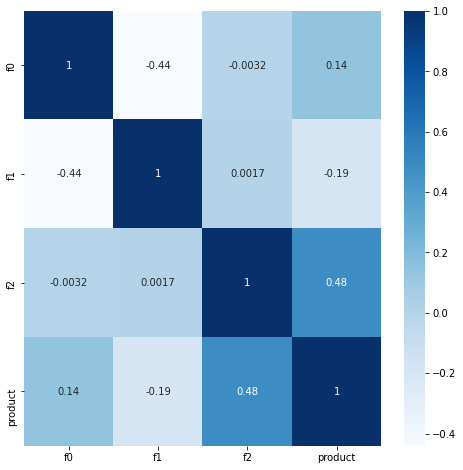

In [14]:
matrix_corr(data_1)

По матрице видно, что самая большая зависимость между признаками `product` и `f2`

**data_2 `heatmap`**

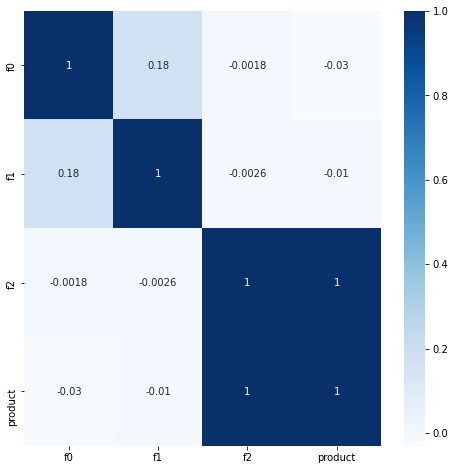

In [15]:
matrix_corr(data_2)

Для второго датасета у `f2` и `product` вообще зависимость максимальная

**data_3 `heatmap`**

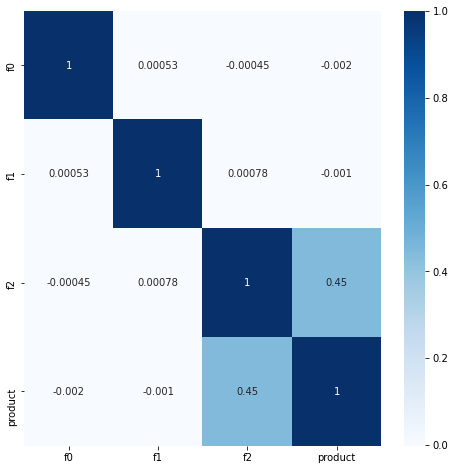

In [16]:
matrix_corr(data_3)

Для 3 региона тоже сильная зависимость между `f2` и `product`

Построим `scater_matrix` для каждого признака, чтобы точнее посмотреть на распределение

**data_1 `scatter_matrix`**

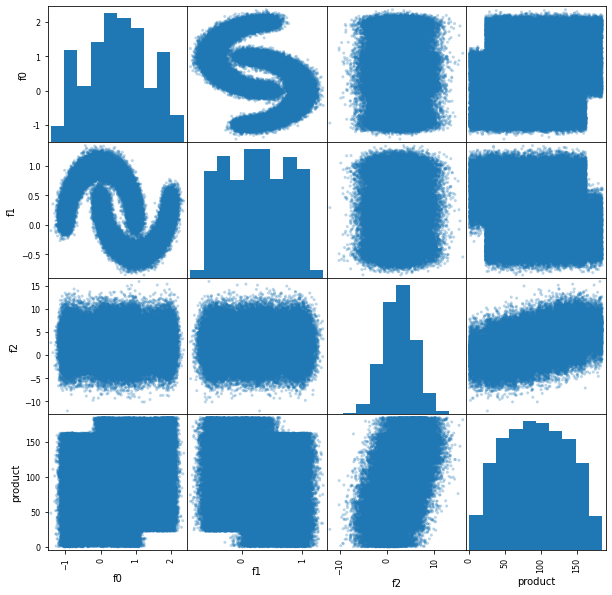

In [17]:
pd.plotting.scatter_matrix(data_1, alpha = 0.3, grid = True, figsize = (10, 10))

plt.show()

**data_2 `scatter_matrix`**

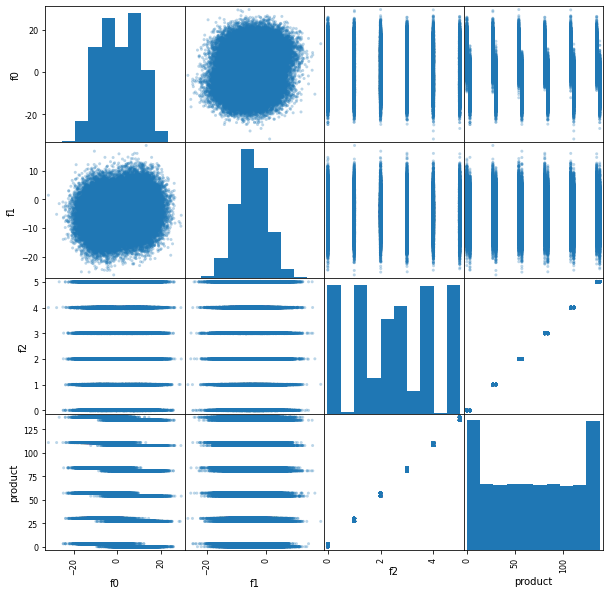

In [18]:
pd.plotting.scatter_matrix(data_2, alpha = 0.3, grid = True, figsize = (10, 10))

plt.show()

**data_3 `scatter_matrix`**

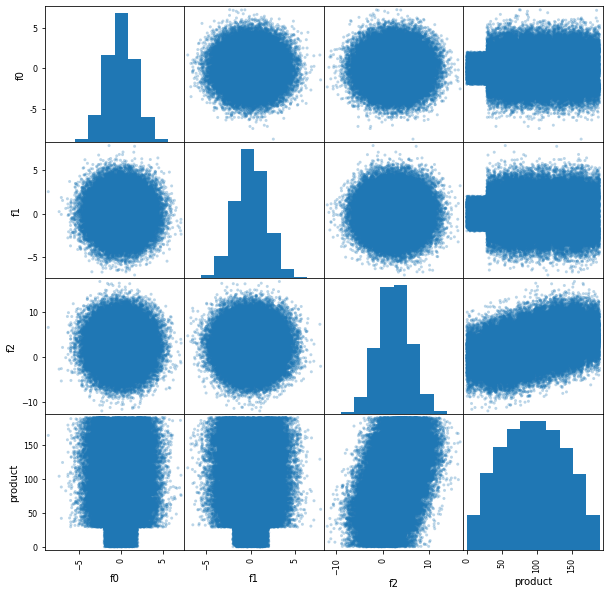

In [19]:
pd.plotting.scatter_matrix(data_3, alpha = 0.3, grid = True, figsize = (10, 10))

plt.show()

- В основном у нас есть линейная зависимость между `f2` и `product`, поэтому этот признак лучше всего поможет при обучении модели линейной регрессии 

**Обучение модели линейной регрессии**

- Прежде всего, нужно разбить данные на обучающую и валидационную выборки в соотношении 75:25.

**Деление выборки для первого региона `data_1`**

In [20]:
random_state = RandomState(1427)

In [21]:
features_1 = data_1.drop('product', axis = 1)
target_1 = data_1['product']

In [22]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, 
                                                                                      target_1, 
                                                                                      test_size = 0.25,
                                                                                      random_state = random_state)


- Т.к. нам необходимо воспользовать линейной регрессией, то нужно масштабировать количественные признаки из выборок

In [23]:
num_cols = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train_1[num_cols])

StandardScaler()

In [24]:
features_train_1_scaled = scaler.transform(features_train_1[num_cols])
features_valid_1_scaled = scaler.transform(features_valid_1[num_cols])

In [25]:
features_valid_1_scaled

array([[-0.47759586,  1.20144135, -0.82681744],
       [ 0.52373127, -0.51534929,  0.46339293],
       [-0.8582829 ,  1.51098308,  0.66651639],
       ...,
       [-0.51447108, -0.58258791, -0.7609333 ],
       [-0.29305937,  1.61320978, -0.58049963],
       [-1.13784982,  1.57760464,  1.94101576]])

- Отлично, теперь сделаем тоже самое для других регионов

**Деление выборки для первого региона `data_2`**

In [26]:
features_2 = data_2.drop('product', axis = 1)
target_2 = data_2['product']

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, 
                                                                                      target_2, 
                                                                                      test_size = 0.25,
                                                                                      random_state = random_state)

scaler = StandardScaler()
scaler.fit(features_train_2[num_cols])

features_train_2_scaled = scaler.transform(features_train_2[num_cols])
features_valid_2_scaled = scaler.transform(features_valid_2[num_cols])

**Деление выборки для первого региона `data_3`**

In [27]:
features_3 = data_3.drop('product', axis = 1)
target_3 = data_3['product']

features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(features_3, 
                                                                                      target_3, 
                                                                                      test_size = 0.25,
                                                                                      random_state = random_state)

scaler = StandardScaler()
scaler.fit(features_train_3[num_cols])

features_train_3_scaled = scaler.transform(features_train_3[num_cols])
features_valid_3_scaled = scaler.transform(features_valid_3[num_cols])

Отлично, данные разделены и масштабированы

- **Обучение и проверка данных метрикой `RMSE` на валидационной выборке для региона 1**

Используем модель `LinearRegression`

In [28]:
model_1 = LinearRegression()
model_1.fit(features_train_1_scaled, target_train_1)


model_1.score(features_valid_1_scaled, target_valid_1)

0.2727249040390751

Какой-то слишком маленький получился коэффициент детерминации, посмотрим что покажет метрика `RMSE`

In [29]:
predictions_1 = model_1.predict(features_valid_1_scaled)

rmse_1 = mean_squared_error(predictions_1, target_valid_1) ** 0.5
print(f'RMSE для первой модели = {int(rmse_1)} %')

RMSE для первой модели = 37 %


**Теперь посмотрим, что покажут другие модели на остальных регионах**

- **Обучение и проверка данных метрикой `RMSE` на валидационной выборке для региона 2**

In [30]:
model_2 = LinearRegression()
model_2.fit(features_train_2_scaled, target_train_2)

model_2.score(features_valid_2_scaled, target_valid_2)

0.9996183743469459

Ого, а здесь хорошее значение, посмотрим, что покажет `RMSE`

In [31]:
predictions_2 = model_2.predict(features_valid_2_scaled)

rmse_2 = mean_squared_error(predictions_2, target_valid_2) ** 0.5
print(f'RMSE для второй модели = {int(rmse_2)} %')
print(f'RMSE для второй модели = {rmse_2} %')

RMSE для второй модели = 0 %
RMSE для второй модели = 0.8951574563108833 %


С этим регионом совсем маленькое значение метрики. Если посмотреть на `heatmap`, который был построен выше, то видно, что именно у второго региона корреляция между `f2` и `product` = 1, поэтому модель и не может найти зависимость между другими признаки и нормально предсказать новые значения. 

- **Обучение и проверка данных метрикой `RMSE` на валидационной выборке для региона 3**

In [32]:
model_3 = LinearRegression()
model_3.fit(features_train_3_scaled, target_train_3)

model_3.score(features_valid_3_scaled, target_valid_3)

0.1970659218720533

Средненький коэффициент детерминации

In [33]:
predictions_3 = model_3.predict(features_valid_3_scaled)

rmse_3 = mean_squared_error(predictions_3, target_valid_3) ** 0.5

print(f'RMSE для третьей модели = {int(rmse_3)} %')

RMSE для третьей модели = 40 %


Тут тоже получили маленькое значение метрики `RMSE`

- По итогу можно сказать, что самая точная модель получилась для первого региона

**Средний запас сырья**

In [34]:
print(f'Средний запас сырья для 1-го региона = {int(predictions_1.mean())} бар.')
print(f'Средний запас сырья для 2-го региона = {int(predictions_2.mean())} бар.')
print(f'Средний запас сырья для 3-го региона = {int(predictions_3.mean())} бар.')

Средний запас сырья для 1-го региона = 92 бар.
Средний запас сырья для 2-го региона = 68 бар.
Средний запас сырья для 3-го региона = 95 бар.


**Промежуточные итоги:**

Итак, были обучены 3 модели `LinearRegression` для каждого из регионов и вот, какие данные были получены:

Метрика `RMSE`:
- Для 1-го региона = 37 % 
- Для 2-го региона = 0  %
- Для 3-го региона = 39 %

Среднее кол-во баррелей нефти:
- Для 1-го региона = 92
- Для 2-го региона = 68
- Для 3-го региона = 94

## Подготовка к расчёту прибыли

**Подготовьтесь к расчёту прибыли:**
 - Все ключевые значения для расчётов сохраните в отдельных переменных.
 - Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 
 - Напишите выводы по этапу подготовки расчёта прибыли.

Первым делом заведем отдельные переменные, в которых будем хранить константы, необходимые для расчетов.

In [35]:
# Бюджет = 10 млрд. руб.
BUDGET = 10000000000 

# Доход с одной единицы = 450 тыс. руб.
INCOME = 450000

# Разведуют 500 точек
ALL_SPOTS = 500

# Выбирают 200 лучших точек
BEST_SPOTS = 200

# После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%
LESION = 0.025

- Рассчитаем объем сырья, чтобы окупилась разработка новой скважины.

Чтобы получить значение длля выхода в ноль, необходимо посчитать отношение `budget` к `income`

In [36]:
BAR_MIN = BUDGET / INCOME
print('Минимальное кол-во тыс. бар. в каждом регионе для выхода в ноль = ', int(BAR_MIN))

Минимальное кол-во тыс. бар. в каждом регионе для выхода в ноль =  22222


То есть, необходимо, чтобы в каждом регионе было минимум 22 тыс. 222 бар. суммарно

Но т.к. по условию отбирают 200 лучших точек, то итоговое значение тоже поделим на 200, чтобы получить значение среднего, которое должно быть в скважинах, чтобы выйти в ноль по прибыли.

In [37]:
TOTAL_MIN = int(BAR_MIN / BEST_SPOTS)
TOTAL_MIN

111

Итого получили значение 111 тыс. бар.

Получается, что в каждой скважине должно быть в среднем 111 тыс. бар. нефти, чтобы выйти в ноль

По итогу, можно сказать, что минимальный объем = 111, но в среднем в каждом регионе у нас намного меньше сырья, чем требуется, поэтому будем смотреть дальше.

**Графики для запасов в регионах**

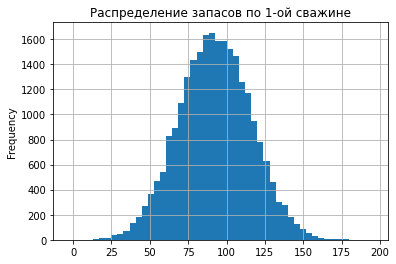

<Figure size 720x720 with 0 Axes>

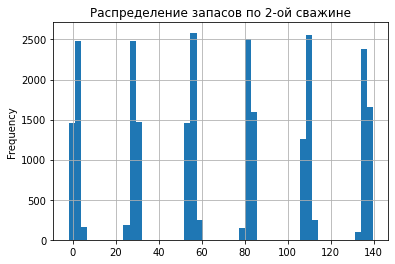

<Figure size 720x720 with 0 Axes>

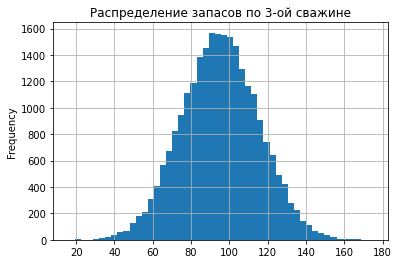

<Figure size 720x720 with 0 Axes>

In [38]:
cols = [predictions_1, predictions_2, predictions_3]
k = 1
for i in cols:
    pd.Series(i).plot(kind = 'hist', bins = 50, grid = True)
    plt.title(f'Распределение запасов по {k}-ой сважине')
    plt.figure(figsize = (10,10))
    k += 1
    plt.show()

По этим графикам видно, что лучшие запасы нефти в 3 регионе

**Промежуточные итоги**

Итак, были посчитаны средние значения в тыс. бар. для скважин, чтобы всё это дело было безубыточным (ушло в 0, хотя бы). Поэтому скорее всего подойдет третий регион, хотя у первого региона на графике более "толстый" пик, что говорит о том, что там больше точек с большим количеством нефти в них. 

## Расчёт прибыли и рисков 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выберите скважины с максимальными значениями предсказаний. 
- Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитайте прибыль для полученного объёма сырья.

Посчитайте риски и прибыль для каждого региона:
- Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [39]:
'''
def money_revenue(preds, target, amount):
    # Список со значениями прибыли
    money = []
    
    # Создаем локальные переменные, в которых будем хранить preds и target
    preds = pd.Series(preds).to_frame()
    target = pd.Series(target).to_frame()

    # Т.к. изначально в target значения были в разброс, то создадим новый столбец с индексами, чтобы их отсортировать
    target['index'] = range(1, len(target) + 1)
    
    # Установка нового столбца как индекс
    target = target.set_index('index')
    preds = preds.rename(columns={0: "product"})
    
    for i in range(amount):
    # Получаем amount лучших значений
        preds_best = preds.sort_values(by = 'product',ascending = False)[:i].index
    
    # Добавляем прибыль в список
        money.append(int(target.loc[preds_best].sum() * income - budget))
    money = pd.Series(money).to_frame()
    money = money / 1000000000
    money.plot()
    plt.ylabel('Доход в млрд.руб.')
    plt.xlabel('Кол-во точек для разработки')
    plt.show()
    #print(money)
    
''' 
    
def money_revenue(preds, target, amount):
    preds = preds.sort_values(ascending=False)
    preds_best = preds[:amount]

    return  (target.loc[preds_best.index]).sum() * INCOME - BUDGET



**Подсчет рисков и прибыли для каждого региона**

Сперва сделаем правильную индексацию в признаках

In [40]:
predictions_1 = pd.Series(predictions_1)
predictions_2 = pd.Series(predictions_2)
predictions_3 = pd.Series(predictions_3)
    
target_valid_1 = pd.Series(np.array(target_valid_1))
target_valid_2 = pd.Series(np.array(target_valid_2))
target_valid_3 = pd.Series(np.array(target_valid_3))

**Регион 1**

In [41]:
arr_1 = []

for i in range(1000):
    preds_sub = predictions_1.sample(n = ALL_SPOTS, 
                                     replace = False, 
                                     random_state = random_state) # Отбираем 500 случайных мсторождений
    
    # Здесь получаем 200 лучших месторождений по мнению модели
    arr_1.append(money_revenue(preds_sub, target_valid_1, BEST_SPOTS)) 


     
    
arr_1 = pd.Series(arr_1)

lower = int(arr_1.quantile(LESION))
higher = int(arr_1.quantile(1-LESION))
print('2.5% квантиль = ',lower)
print('97.5% кввантиль = ', higher)


mean_arr_1 = int(arr_1.mean())
print('Среднее равно = ', mean_arr_1)


2.5% квантиль =  -158667698
97.5% кввантиль =  827632679
Среднее равно =  344205642


**Регион 2**

In [42]:
arr_2 = []

for i in range(1000):
    preds_sub = predictions_2.sample(n = ALL_SPOTS, 
                                     replace = False, 
                                     random_state = random_state) # Отбираем 500 случайных мсторождений
    
    # Здесь получаем 200 лучших месторождений по мнению модели
    arr_2.append(money_revenue(preds_sub, target_valid_2, BEST_SPOTS)) 


     
    
arr_2 = pd.Series(arr_2)

lower = int(arr_2.quantile(LESION))
higher = int(arr_2.quantile(1-LESION))
print('2.5% квантиль = ',lower)
print('97.5% кввантиль = ', higher)


mean_arr_2 = int(arr_2.mean())
print('Среднее равно = ', mean_arr_2)


2.5% квантиль =  46694319
97.5% кввантиль =  800281063
Среднее равно =  439658932


**Регион 3**

In [43]:
arr_3 = []

for i in range(1000):
    preds_sub = predictions_3.sample(n = ALL_SPOTS, 
                                     replace = False, 
                                     random_state = random_state) # Отбираем 500 случайных мсторождений
    
    # Здесь получаем 200 лучших месторождений по мнению модели
    arr_3.append(money_revenue(preds_sub, target_valid_3, BEST_SPOTS)) 


     
    
arr_3 = pd.Series(arr_3)

lower = int(arr_3.quantile(LESION))
higher = int(arr_3.quantile(1-LESION))
print('2.5% квантиль = ',lower)
print('97.5% кввантиль = ', higher)


mean_arr_3 = int(arr_3.mean())
print('Среднее равно = ', mean_arr_3)


2.5% квантиль =  -168222367
97.5% кввантиль =  882886442
Среднее равно =  326779505


**Выведем все средние значения**

In [44]:
print(f'Среднее значение прибыли для 1-го региона = {round(mean_arr_1 / 1000000000, 2)} млрд. руб.')
print(f'Среднее значение прибыли для 2-го региона = {round(mean_arr_2 / 1000000000, 2)} млрд. руб.')
print(f'Среднее значение прибыли для 3-го региона = {round(mean_arr_3 / 1000000000, 2)} млрд. руб.')

Среднее значение прибыли для 1-го региона = 0.34 млрд. руб.
Среднее значение прибыли для 2-го региона = 0.44 млрд. руб.
Среднее значение прибыли для 3-го региона = 0.33 млрд. руб.


**Для каждого региона подсчитаем шанс выйти в +**

In [45]:
print(f'Шанс для 1-го региона выйти в плюс = {int( (arr_1 > 0).mean() * 100 )} %')
print(f'Шанс для 2-го региона выйти в плюс = {int( (arr_2 > 0).mean() * 100 )} %')
print(f'Шанс для 3-го региона выйти в плюс = {int( (arr_3 > 0).mean() * 100 )} %')

Шанс для 1-го региона выйти в плюс = 92 %
Шанс для 2-го региона выйти в плюс = 98 %
Шанс для 3-го региона выйти в плюс = 87 %


**Итог:**

- Итак, исходя из полученных значений, видно, что регион 2 является самым перспективным и в приоритете самым прибыльным (98 % окупить затраты и выйти в плюс) и среднее предполагаемое значение прибыли для 2 региона = 0.45 млрд. руб.

## Выводы:

   В ходе работы предстояло помочь нефтедобывающей компании проанализировать месторождения нефти в трех регионах, и с помощью модели Линейной Регрессии предсказать значения для нефти в тыс. барр.

**Работа была поделена на несколько этапов:**
- Загрузка и первичная предобработка данных 
- Обучение модели для каждого из регионов
- Расчет прибыли 
- Оценка рисков

Для каждого региона мы получили предсказанные моделью значения, а на их основе подсчитали прибыль и риски. По итогу, регион 1 оказался самым перспективным с прибылью 0.45 млрд. руб. и шансом окупиться в 98 %.



## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован